# Logistic Regression in Julia

File explaining logistic regression as seen in class.

## Reading of the data

In [1]:
using DelimitedFiles
using Statistics
using LinearAlgebra
using Plots
using RDatasets: dataset
using CategoricalArrays

In [2]:
iris = dataset("datasets", "iris");

In [3]:
X = Matrix(iris[:,1:end-1]);
y = iris[:,end];

## Feature Normalizacion

We will apply the same normalization as in linear regression.

In [4]:
function normalization(x::Vector{Float64})
    return (x.-mean(x))/std(x)
end;

In [ ]:
X= mapslices(normalization, X; dims = 1);

In [ ]:
y = levelcode.(y);

## Hypothesis Function

Next we define a multivariate form of the hypothesis function:
The sigmoid function is

$$
g(x) = \frac{1}{1+e^{-x}}
$$

We can use the same function as in the linear regression, but we apply a sigmoid function to it.

Then, we can calculate the hypothesis function as:

$$
h_\theta(X)=g(X\theta)
$$

In [ ]:
X = [ones(size(X)[1]) X];

In [ ]:
theta = rand(size(X)[2],size(levels(y))[1]);

In [10]:
logistic(z) = 1/(1+exp(-z));

In [ ]:
h(theta, X, i) = logistic.(X * theta[:,i]);

## Cost Function

We can define the cost function as:

$$
E(\theta)=\frac{1}{m} \sum_{i=1}^m Cost(h_\theta (x^{(i)}), y^{(i)})
$$

where

$$
Cost(h_\theta(x),y)=
\begin{cases}
    -\log(h_\theta(x)) \quad &y=1 \\
    -\log(1-h_\theta(x)) \quad &y=0
\end{cases}
$$

We can combine the cost function to be

$$
Cost(h_\theta(x),y)=-y\log(h_\theta(x))-(1-y)\log(1-h_\theta(x))
$$

The vectorized verision would be

$$
\begin{align*}
h&=g(X\theta)\\
E(\theta)&=\frac{1}{m}\cdot \left(-y^T \log(h)- (1-y)^T \log(1-h) \right)
\end{align*}
$$

In [ ]:
m = size(X)[1];

In [16]:
cost(h,y) = -transpose(y) * log.(h)- ((-transpose(y).+1)*log.(-h.+1))[1];

In [ ]:
E(theta, i) = cost(h(theta,X, i), Vector(y.==i))[1]/m;

To be able to modify the values of $\theta$ we need to calculate the derivative of $E(\theta)$. When we calculate the derivative, we can see that

$$
\begin{align*}
&&\frac{\partial E(\theta)}{\partial \theta_j}
    &= \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)} &&\\
 \implies && \nabla E(\theta) &= \frac{1}{m} X^{T}  ( g(X\theta) - y ) &&\\
\end{align*}
$$

Using this, we can modify the values of $\theta$ using

$$
\theta := \theta - \frac{\alpha}{m} X^T (g(X\theta) -y)
$$

Where $\alpha$ is the learning rate.

In [ ]:
grad_E(theta, i) = 1/m * transpose(X) * (logistic.(X*theta[:,i]) - Vector(y.==i));

In [ ]:
alpha = 0.01;

Using this, we can see the cost associated with $\theta$.

In [ ]:
E(theta,1)

We can see how the training improves $\theta$ and reduces the cost.
(Normally it should be run until convergence is seen but this here is just an example.)

In [ ]:
# Every time we run it, theta is improved. It should be run until convergence
j=3
err_hist = [E(theta,j)]
for i in 1:10000
    theta[:,j] -= alpha*grad_E(theta, j)
    theta_hist = vcat(theta_hist, transpose(theta[:,j]))
    append!(err_hist, E(theta,j))
end
E(theta, j)

In [ ]:
plot(err_hist)

## Putting everything together

To make it easier to solve a problem and train it, we can put everything together in a structure, so we can normalize the data automatically after reading it and save the values of the mean and std for future predictions.
For multiple classes multiple binary logistic regressions are necessary. To do this, we will be using matrixes instead of vectors on the $y$ vector, using One Hot Encoding.

In [5]:
mutable struct LR_Problem
    X::Matrix{Float64}       # Normalized data
    y::Vector{Int}       # Normalized vector
    X_mean::Matrix{Float64}  # Means of X matrix per column
    X_std::Matrix{Float64}   # STD of X matrix per colum
    theta::Matrix{Float64}       # Weights and biases
    alpha::Float64               # Learning rate
    tol::Float64             # Tolerance of error for convergence
    
    function LR_Problem(X::Matrix{Float64}, y::CategoricalArray; alpha = 0.01::Float64, tol = 1e-2::Float64)
        X_mean = mapslices(mean, X; dims = 1)
        X_std = mapslices(std, X; dims = 1)
        X = mapslices(normalization, X; dims = 1)
        X = [ones(size(X)[1]) X];
        y = levelcode.(y)
        num_cat = size(levels(y))[1]
        if num_cat == 2
            num_cat = 1
        end
        
        theta = rand(size(X)[2],num_cat)
        new(X, y, X_mean, X_std, theta, alpha, tol)
    end
end;  

In [8]:
function compute_cost(prob::LR_Problem)
    m = size(prob.X)[1]
    h = logistic.(prob.X * prob.theta)
    y_h = -(prob.y'.==unique(prob.y))
    return diag(y_h * log.(h) - (y_h.+1) * log.(-h.+1))./m
end;

In [16]:
function compute_gradients(prob::LR_Problem)
    m = size(prob.X)[1]
    h = logistic.(prob.X * prob.theta)
    y_h = prob.y.==unique(prob.y)'
    return transpose(prob.X) * (h-(prob.y.==unique(prob.y)'))/m
end;

In [46]:
function train!(prob::LR_Problem; max_iter  = 10000::Int64, err_hist = transpose(compute_cost(prob)))
    iter = 0
    # Train while it has not converged or reach 10000 iterations
    gradients = compute_gradients(prob)
    while norm(gradients,2)>prob.tol && iter<=max_iter
        prob.theta -= prob.alpha * gradients
        gradients = compute_gradients(prob)
        if iter%100==0
            err_hist = vcat(err_hist,transpose(compute_cost(prob)))
        end
    end
    return err_hist
end;

In [126]:
function predict(prob::LR_Problem, x::Matrix{Float64})
    x = (x-prob.X_mean)./prob.X_std # normalize the vector
    x = hcat(1, x) # add first column of 1
    y = logistic.(x * prob.theta) # predict
    return argmax(y)[2]
end;

In [129]:
prob = LR_Problem(X,y);

In [139]:
errs = train!(prob);

We can see the errors of the different individual binary logistic regressions.

In [138]:
plot(errs[1:50000,1])
plot!(errs[1:50000,2])
plot!(errs[1:50000,3])

Here we can see the division of the classes using only three of the different variables.

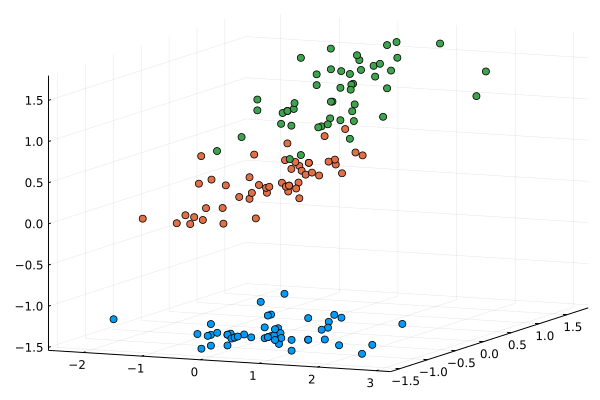

In [222]:
scatter(prob.X[:,3],prob.X[:,4],prob.X[:,5], color= prob.y, legend=nothing)

In [199]:
preds = mapslices(argmax, logistic.(prob.X*prob.theta); dims = 2);

We can see that the predictions are very similar to the real data. Drawing the decision bounaries can be difficult here, but we can see that the decision boundaries are defined correctly.

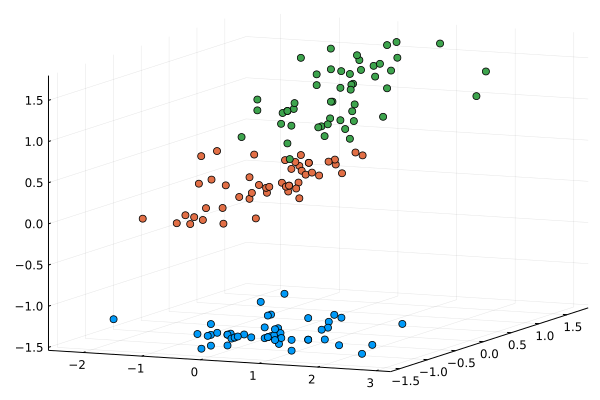

In [221]:
scatter(prob.X[:,3],prob.X[:,4],prob.X[:,5], color= preds, legend=nothing)

And to make predictions, we can just use the predict function.

In [224]:
x = [6 3 4.8 1.8];
predict(prob, x)

3